In [1]:
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import math
from matplotlib.ticker import FuncFormatter
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

# plt.rcParams.update({'font.size': 12})
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# format a time delta
def format_func(x, pos):
    hours = int(x//3600)
    minutes = int((x%3600)//60)
    seconds = int(x%60)
    return "{:d}:{:02d}:{:02d}".format(hours, minutes, seconds)

timedelta_formatter = FuncFormatter(format_func)

In [2]:
sys.path.append('.')

In [3]:
import tools_graph
import tools_data

In [4]:
experiment_set = "data/freqV3"
experiments = tools_data.getExperimentsInSet(experiment_set)

In [5]:
experiments

['5_8_112500_1_0_0_0_20210914_1104',
 '5_6_180000_1_0_0_0_20210914_1132',
 '5_10_90000_1_0_0_0_20210914_1035',
 '5_100_9000_1_0_0_0_20210914_1007',
 '5_1000_1000_1_0_0_0_20210914_0938']

5_8_112500_1_0_0_0_20210914_1104
5_6_180000_1_0_0_0_20210914_1132
5_10_90000_1_0_0_0_20210914_1035
5_100_9000_1_0_0_0_20210914_1007
5_1000_1000_1_0_0_0_20210914_0938


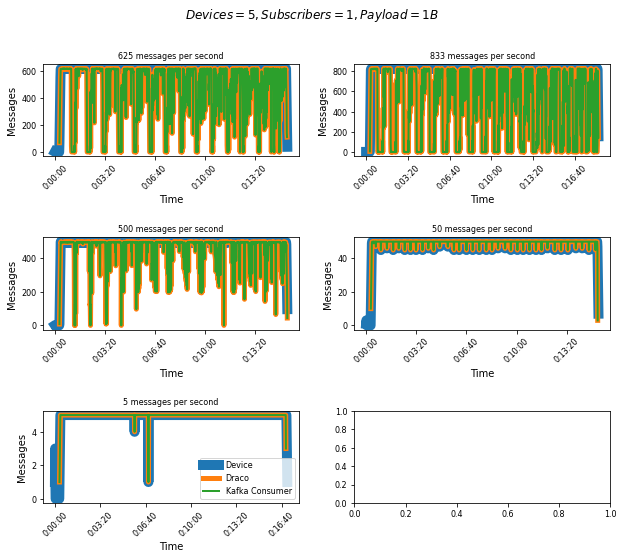

In [6]:
# TODO: sort charts by ascending number of messages
# TODO: what if we have more than 5 messages? Foreach changing variable (i.e., devices, frequency, paylaod, subscriber),
#       we need to produce a matrix of charts
# TODO: parametrize fig.suptitle
# TODO: remove last chart if useless (i.e., |experiments| < ny * nx)
# TODO: produce the results for the predefined values

ny = math.ceil(len(experiments) / 2)
nx = 1 if len(experiments) == 1 else 2
fig, ax = plt.subplots(nrows=ny, ncols=nx, figsize=(3 * ny, 4 * nx))

def time_count(ax, devices, consumer, title):
    res = pd.DataFrame()
    res["Device"] = devices.resample("1s", on="datetime").count()["datetime"]
    res["Draco"] = consumer.resample("1s", on="datetime").count()["Draco Timestamp"]
    res["Kafka Consumer"] = consumer.resample("1s", on="datetime").count()["Consumer Timestamp"]
    res = res.reset_index()
    res["datetime"] = (res["datetime"] - res["datetime"].min()).apply(lambda x: x) # strfdelta(x, '%H:%M:%S'))

    ax = res["Device"].plot(ax=ax, linewidth=10)
    ax = res["Draco"].plot(ax=ax, linewidth=5)
    ax = res["Kafka Consumer"].plot(ax=ax, linewidth=2)

    ax.set_xlabel("Time")
    ax.set_ylabel("Messages")
    ax.set_title(title)
    ax.xaxis.set_major_formatter(timedelta_formatter)
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=70)
    ax.tick_params(axis='x', rotation=45)
    # plt.xticks(rotation=70)
    

i = 0
for experiment in experiments:
    print(experiment)
    params = experiment.split("_")
    params = [int(p) for p in params]

    consumer = tools_data.readConsumer(experiment_set, experiment)
    device_aggregate = tools_data.readAggregateDevices(experiment_set, experiment)
    time_count(ax[int(i/2)][i%2], device_aggregate, consumer, "{} messages per second".format(int(params[0]*(1000/params[1]))))
    i += 1

i -= 1
ax[int(i/2)][i%2].legend()
fig.suptitle("$Devices = 5, Subscribers = 1, Payload = 1B$")
fig.tight_layout()

5_8_112500_1_0_0_0_20210914_1104
5_6_180000_1_0_0_0_20210914_1132
5_10_90000_1_0_0_0_20210914_1035
5_100_9000_1_0_0_0_20210914_1007
5_1000_1000_1_0_0_0_20210914_0938


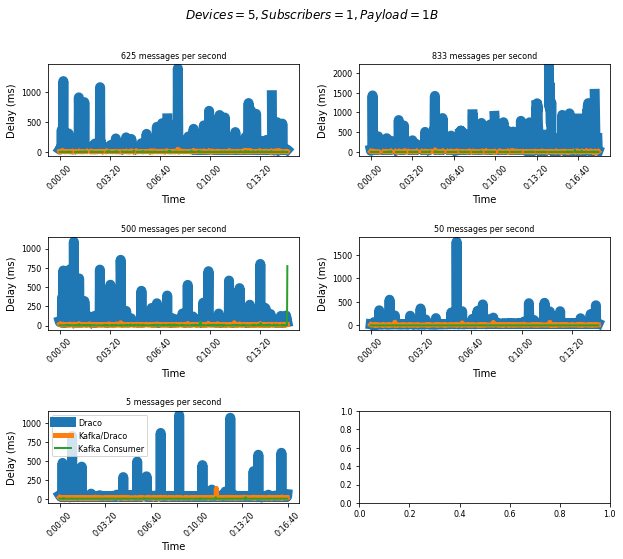

In [7]:
ny = math.ceil(len(experiments) / 2)
nx = 1 if len(experiments) == 1 else 2

fig, ax = plt.subplots(nrows=ny, ncols=nx, figsize=(3 * ny, 4 * nx))

def time_delay(ax, consumer, title):
    delayDracoDevice = consumer.resample("1s", on='datetime').mean()["Delay Draco/Device"]
    delayKafkaDraco = consumer.resample("1s", on='datetime').mean()["Delay Kafka/Draco"]
    delayKafkaConsumer = consumer.resample("1s", on='datetime').mean()["Delay Kafka Consumer"]
    
    res = pd.DataFrame()
    res["Draco"] = delayDracoDevice
    res["Kafka/Draco"] = delayKafkaDraco
    res["Kafka Consumer"] = delayKafkaConsumer
    res = res.reset_index()
    res["datetime"] = (res["datetime"] - res["datetime"].min()).apply(lambda x: x) # strfdelta(x, '%H:%M:%S'))
    
    ax = res["Draco"].plot(ax=ax, linewidth=10)
    ax = res["Kafka/Draco"].plot(ax=ax, linewidth=5)
    ax = res["Kafka Consumer"].plot(ax=ax, linewidth=2)
    
    ax.set_xlabel("Time")
    ax.set_ylabel("Delay (ms)")
    ax.set_title(title)
    ax.xaxis.set_major_formatter(timedelta_formatter)
    ax.tick_params(axis='x', rotation=45)
    

i = 0
for experiment in experiments:
    print(experiment)
    params = experiment.split("_")
    params = [int(p) for p in params]

    consumer = tools_data.readConsumer(experiment_set, experiment)
    device_aggregate = tools_data.readAggregateDevices(experiment_set, experiment)
    time_delay(ax[int(i/2)][i%2], consumer, "{} messages per second".format(int(params[0]*(1000/params[1]))))
    i += 1

i -= 1
ax[int(i/2)][i%2].legend()
fig.suptitle("$Devices = 5, Subscribers = 1, Payload = 1B$")
fig.tight_layout()

['5', '1000', '1000', '1', '0', '0', '0', '20210914', '0938']
['5', '100', '9000', '1', '0', '0', '0', '20210914', '1007']
['5', '10', '90000', '1', '0', '0', '0', '20210914', '1035']
['5', '6', '180000', '1', '0', '0', '0', '20210914', '1132']
['5', '8', '112500', '1', '0', '0', '0', '20210914', '1104']


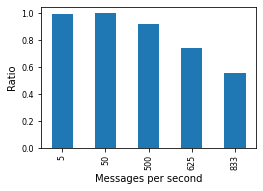

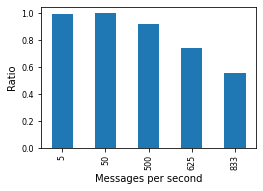

In [8]:
def cumulative(experiment_set, xlabel, ylabel, mapper, mapper2):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 3))
    metrics = {}
    experiments = os.listdir(experiment_set)
    for experiment in experiments:
        consumer = tools_data.readConsumer(experiment_set, experiment) # read consumer data
        devices = tools_data.readAggregateDevices(experiment_set, experiment) # read data from devices, the two can differ due to message loss
        params = experiment.split("_")
        print(params)
        label = mapper(params)
        metrics[label] = mapper2(consumer, devices)
       
    result = pd.DataFrame.from_dict(metrics, orient="index")
    result.index = result.index.astype(float)
    result = result.sort_index()  
    
    ax = result.plot(ax=ax, kind="bar", legend=False)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticklabels([int(x) for x in sorted(list(metrics.keys()))])
    fig.tight_layout()
    return fig

l =  lambda params: int(params[0]) * (1000/int(params[1]))
cumulative(experiment_set, "Messages per second", "Ratio", l, lambda consumer, devices: consumer.shape[0] / devices.shape[0])

['5', '1000', '1000', '1', '0', '0', '0', '20210914', '0938']
['5', '100', '9000', '1', '0', '0', '0', '20210914', '1007']
['5', '10', '90000', '1', '0', '0', '0', '20210914', '1035']
['5', '6', '180000', '1', '0', '0', '0', '20210914', '1132']
['5', '8', '112500', '1', '0', '0', '0', '20210914', '1104']


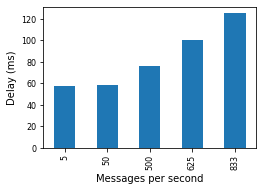

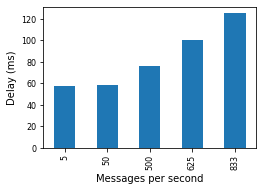

In [9]:
cumulative(experiment_set, "Messages per second", "Delay (ms)", l, lambda consumer, devices: consumer["Delay Consumer/Device"].mean())

In [10]:
tools_data.readConsumer(experiment_set, experiment).describe()

,Kafka Timestamp,Draco Timestamp,Device Timestamp,Consumer Timestamp,Delay Draco/Device,Delay Kafka/Draco,Delay Kafka/Device,Delay Consumer/Device,Delay Kafka Consumer
count,4.978000e+03,4.978000e+03,4.978000e+03,4.978000e+03,4978.000000,4978.000000,4978.000000,4978.000000,4978.000000
mean,1.631613e+12,1.631613e+12,1.631613e+12,1.631613e+12,41.526517,13.553234,55.079751,57.423865,2.344114
std,2.878268e+05,2.878258e+05,2.878273e+05,2.878266e+05,74.562051,9.666764,75.455442,75.593904,2.250334
min,1.631612e+12,1.631612e+12,1.631612e+12,1.631612e+12,13.000000,0.000000,18.000000,20.000000,1.000000
25%,1.631613e+12,1.631613e+12,1.631613e+12,1.631613e+12,28.000000,11.000000,40.000000,42.000000,2.000000
50%,1.631613e+12,1.631613e+12,1.631613e+12,1.631613e+12,32.000000,12.000000,46.000000,48.000000,2.000000
75%,1.631613e+12,1.631613e+12,1.631613e+12,1.631613e+12,38.000000,16.000000,52.000000,55.000000,3.000000
max,1.631613e+12,1.631613e+12,1.631613e+12,1.631613e+12,1133.000000,625.000000,1150.000000,1153.000000,103.000000


In [11]:
tools_data.readAggregateDevices(experiment_set, experiment).describe()

C:\Users\MATTEO~1.FRA\AppData\Local\Temp/ipykernel_183368/390712936.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  tools_data.readAggregateDevices(experiment_set, experiment).describe()


,deviceID,status,datetime
count,5005,5005,5005
unique,5,1,3421
top,device1000,true,2021-09-14 09:46:52.967000
freq,1001,5005,4
first,NaN,NaN,2021-09-14 09:40:27.752000
last,NaN,NaN,2021-09-14 09:57:31.969000
